# Import the Relevant Libraries

In [1]:
import os
import io
import mimetypes
import time
import logging
import openai
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient

# Add environment variables

In [303]:
AZURE_SEARCH_SERVICE = os.environ.get("AZURE_SEARCH_SERVICE") or "acsopenidmo"
AZURE_SEARCH_INDEX = os.environ.get("AZURE_SEARCH_INDEX") or "azureblob-index"
AZURE_OPENAI_SERVICE = os.environ.get("AZURE_OPENAI_SERVICE") or "openaidmo1"
AZURE_OPENAI_GPT_DEPLOYMENT = os.environ.get("AZURE_OPENAI_GPT_DEPLOYMENT") or "embed"
AZURE_OPENAI_CHATGPT_DEPLOYMENT = os.environ.get("AZURE_OPENAI_CHATGPT_DEPLOYMENT") or "chat"

# Add variables related to the Azure search fields

In [3]:
KB_FIELDS_CONTENT = os.environ.get("KB_FIELDS_CONTENT") or "content"
KB_FIELDS_CATEGORY = os.environ.get("KB_FIELDS_CATEGORY") or "category"
KB_FIELDS_SOURCEPAGE = os.environ.get("KB_FIELDS_SOURCEPAGE") or "sourcepage"

# Fetch Azure credentials

In [4]:
azure_credential = DefaultAzureCredential()

# Add Azure OpenAI endpoint and Key

In [5]:
openai.api_type = "azure"
openai.api_base = "https://openaidmo1.openai.azure.com/"
openai.api_version = "2023-05-15" 

In [6]:
openai.api_key = "248b27f12e41421ea22f6f44df69f8a6"

# Invoking the Azure Search Client

In [7]:
search_client = SearchClient(
    endpoint=f"https://{AZURE_SEARCH_SERVICE}.search.windows.net",
    index_name=AZURE_SEARCH_INDEX,
    credential=azure_credential)

# Now the Real Fun begins! 
Ask a question based on the input stories that are indexed in Azure Search. 

In [272]:
question="tell me about star wars movie?"

# Create a prompt to generate a completion with the new user query and previous queries

In [273]:
query_prompt_template = """As an assistant, generate a search query based on history and new user query.
        Do not add any new information outside what is asked.
    Chat History:
    {chat_history}
    Question:
    {question}
    Search query:
    """
response = openai.ChatCompletion.create(
    engine="chat", 
    messages=[
        {"role": "system", "content": query_prompt_template},
        {"role": "user", "content": question}
    ],
    temperature=0.1
)


In [274]:
print(response)

{
  "id": "chatcmpl-7ZL54BROz6wie3AqlWR2fKzvqgp8m",
  "object": "chat.completion",
  "created": 1688656870,
  "model": "gpt-35-turbo",
  "choices": [
    {
      "index": 0,
      "finish_reason": "stop",
      "message": {
        "role": "assistant",
        "content": "star wars movie"
      }
    }
  ],
  "usage": {
    "completion_tokens": 3,
    "prompt_tokens": 67,
    "total_tokens": 70
  }
}


# Fetch the generated question, with proper context, from the Chat Response

In [275]:
q = response['choices'][0]['message']['content']
query=q.split(':')[-1]
print(query)

star wars movie


# Use the Search Client to search for the relevant document in the Knowledge base

In [276]:
from azure.core.credentials import AzureKeyCredential
AZURE_SEARCH_SERVICE = os.environ.get("AZURE_SEARCH_SERVICE") or "acsopenidmo"
AZURE_SEARCH_INDEX = os.environ.get("AZURE_SEARCH_INDEX") or "azureblob-index"
key = "IIWOWg6fOvGSk4iI10wJQERsiKnPGa01B3GeROdpwgAzSeBrM0jQ"
credential = AzureKeyCredential(key)
client = SearchClient(endpoint="https://acsopenidmo.search.windows.net",
                      index_name=AZURE_SEARCH_INDEX,
                      credential=credential)

In [277]:
r = client.search(query, filter=None, top=1)
results = [(doc['content']) for doc in r]
try:
    content=results[0]
except:
    content=results

In [278]:
print(content)

A series of photos have emerged from the ultra-secretive Abu Dhabi set of Star Wars: Episode VII and although none of the franchise’s big stars put in an appearance, the pictures offer some encouraging first signs of what fans can expect from the new movie.

Director J.J. Abrams began shooting the highly anticipated film last month and while little is known about the script, the photos suggest a back to basics style to filming, shunning the unpopular CGI-heavy approach of George Lucas’ prequels.

The photos reveal many encouraging signs for fans of the original trilogy. Abu Dhabi is believed to be a stand-in for the desert planet of Tatooine, Luke Skywalker’s home planet.

Scroll down for video

A series of photos have emerged from the ultra-secretive Abu Dhabi set of Star Wars: Episode VII including a massive four-legged alien creature that looks like a cross between a rhinoceros, a pig and a bulldog

Director J.J. Abrams began shooting the highly anticipated film last month and while

# Create another prompt that will use the fetched document and summarize the the content with meaningful response.

In [286]:
prompt_prefix = """<|im_start|>system
    Assistant helps the researcher to find relavant information about general knowledge question based on story document. Be brief in your answers.
    Answer ONLY with the facts listed in the list of sources below. If there isn't enough information below, say you don't know. Do not generate answers that don't use the sources below.
    Sources:
    {sources}
    <|im_end|>
    """
try:
    prompt=prompt_prefix.format(sources=query+""+content)
except:
    prompt=prompt_prefix.format(sources=query+""+str(content))

# Call the ChatCompletion function to summarize the content

In [287]:
completion = openai.ChatCompletion.create(
    engine="chat", 
    messages=[
        {"role": "system", "content": prompt_prefix},
        {"role": "user", "content": prompt}
        ],
    temperature=1, 
    max_tokens=1024, 
    n=1, 
    stop=["<|im_end|>", "<|im_start|>"])


In [288]:
q2 = completion['choices'][0]['message']['content']

# Print the meaningful summary.

In [289]:
print(q2)

Based on the sources provided:

- Photos have emerged from the set of Star Wars: Episode VII in Abu Dhabi, showing a back to basics style of filming without heavy CGI.
- The photos suggest that Abu Dhabi is a stand-in for the desert planet Tatooine, Luke Skywalker's home planet.
- One of the photos shows a large, four-legged alien creature manned by a five-man team, set to appear in two scenes in a market place on Tatooine.
- Another photo shows two busted robots that resemble R2D2, possibly remnants of a pod-racer.
- Extras dressed in muted colored costumes can be seen taking selfies on the set.
- Star Wars Episode VII is set to be released worldwide on December 18, 2015.




In [290]:
import openai
import re
import requests
import sys
from num2words import num2words
import os
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity
from transformers import GPT2TokenizerFast

In [291]:
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()
    
    return s


In [292]:
norm_query=normalize_text(query)

In [293]:
norm_answer = normalize_text(q2)

In [294]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
norm_query_token=tokenizer.encode(norm_query)
norm_answer_token=tokenizer.encode(norm_answer)

In [295]:
len(norm_query_token)

3

In [296]:
len(norm_answer_token)

154

In [297]:
embed_query=get_embedding(norm_query,engine=AZURE_OPENAI_GPT_DEPLOYMENT)
embed_answer=get_embedding(norm_answer,engine=AZURE_OPENAI_GPT_DEPLOYMENT)

In [298]:
similarity=cosine_similarity(embed_query,embed_answer)

In [299]:
print(similarity)

0.8593401243288376


In [300]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [301]:
combined_sentence=[query+q2]
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(combined_sentence))

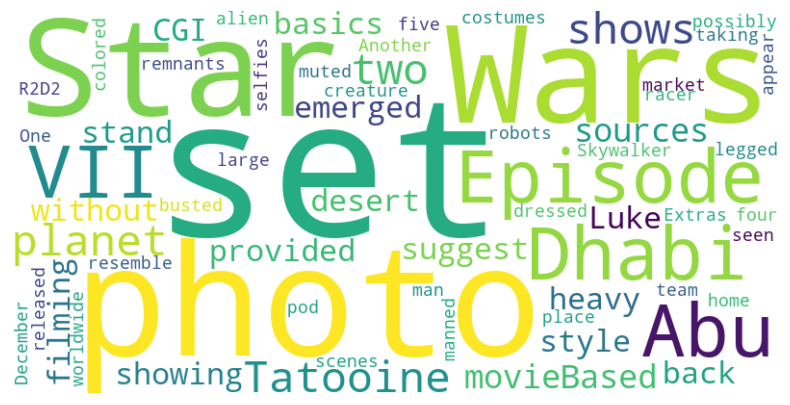

In [302]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()